# Y2K references classification

### Imports

In [81]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report


### Functions for plot results

In [2]:
def evaluate_model(y_true, y_pred, title, average='macro'):
    print(f"\n{title}")
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred, average=average), 4))
    print("Recall   :", round(recall_score(y_true, y_pred, average=average), 4))
    print("F1-score :", round(f1_score(y_true, y_pred, average=average), 4))
    print("\nОтчёт по классам:\n", classification_report(y_true, y_pred))


In [3]:
def plot_confusion_matrix(y_true, y_pred, title):
    class_names = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=class_names)

    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', 
        xticklabels=class_names, yticklabels=class_names 
    )
    
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.title(f'Матрица ошибок {title}')
    plt.show()


In [4]:
def plot_training_history(train_accuracies, valid_accuracies, 
                         train_losses, valid_losses, num_epochs,
                         title="Training History"):
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(title, fontsize=16)
    
    epochs_range = range(1, num_epochs + 1)
    
    ax1 = axes[0]
    ax1.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
    ax1.plot(epochs_range, valid_accuracies, label="Valid Accuracy", marker='s')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Training vs Validation Accuracy")
    ax1.legend()
    
    ax2 = axes[1]
    ax2.plot(epochs_range, train_losses, label="Train Loss", marker='o')
    ax2.plot(epochs_range, valid_losses, label="Valid Loss", marker='s')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title("Training vs Validation Loss")
    ax2.legend()
    
    plt.show()


### Setting up device

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


device = get_device()
print(f"Using device: {device}")

Using device: mps


## Load Data

In [6]:
data_path = '/Users/albertzagibin/Documents/Стартап/Тестовое/data'

Зададим аугментацию для обучающей и тестовой выборки

In [7]:
train_transforms = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [8]:
train_dataset = torchvision.datasets.ImageFolder(
    root='/Users/albertzagibin/Documents/Стартап/Тестовое/data/train', 
    transform=train_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    root='/Users/albertzagibin/Documents/Стартап/Тестовое/data/test', 
    transform=test_transforms
)


In [9]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False, 
)


Примеры, что мы подаем на вход нейронки

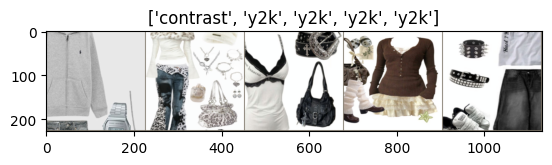

In [13]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.Figure(figsize=(20,12))
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

class_names = train_dataset.classes

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])

imshow(out, title=[class_names[x] for x in classes][:5])

## ResNet18 from scratch

In [14]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(
            self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, 
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)

        self.conv2 = nn.Conv2d(
            intermediate_channels, intermediate_channels, 
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride
        
    def forward(self, x): 
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x 


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, p=0.5, num_classes=2):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(BasicBlock, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(BasicBlock, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(BasicBlock, layers[3], intermediate_channels=512, stride=1)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.d = nn.Dropout(p=p)
        self.fc = nn.Linear(512 * block.expansion, num_classes)   
        

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * block.expansion:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * block.expansion),
            )
        
        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        self.in_channels = intermediate_channels * block.expansion
        for _ in range(num_residual_blocks-1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)  
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.d(x)
        x = self.fc(x)

        return x


In [16]:
def ResNet18(p=0.5, img_channel=3, num_classes=2):
    return ResNet(BasicBlock,[2,2,2,2],img_channel, p=p ,num_classes=num_classes)

### Train model functions

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        _pred = model(images)
        loss = criterion(_pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            pred = model(images)
            loss = criterion(pred, labels)

            total_loss += loss.item()

            _, preds = torch.max(pred, 1) #pred.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += len(labels)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, device, num_epochs = 10):
    best_model_state = None
    best_valid_loss = float("inf")

    train_accuracies = []
    valid_accuracies = []
    train_losses = []
    valid_losses = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

        _, train_acc = evaluate(model, train_loader, criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)

        print(f"Epoch {epoch}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")

        scheduler.step()

        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_state = deepcopy(model.state_dict())

    model.load_state_dict(best_model_state)
    model.eval()
    print(f'Best Valid Loss {best_valid_loss}')

    return model, train_accuracies, valid_accuracies, train_losses, valid_losses

In [18]:
model = ResNet18(p=0.4, img_channel=3, num_classes=2).to(device)
y = model(torch.randn(4, 3, 224, 224).to(device)).to(device)
assert y.size() == torch.Size([4, 2])
print(y.size())

torch.Size([4, 2])


## Подбор гипперпараметра p - вероятность Дропаута

Почему используем дропаут? 
Без него модель имела склонность к переобучению и на выходе по метрикам F1-score был около 0.7-0.78 и Модель старалась все чаще ставить метку Y2K.

In [ ]:
results = {}
num_trials = 10
p_values = [round(random.uniform(0.2, 0.5), 2) for _ in range(num_trials)]
num_epochs = 30

for p in p_values:
    print(f"\n=== Training with dropout p={p} ===")
    
    model = ResNet18(p=p, img_channel=3, num_classes=2).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

    best_val_acc = 0.0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_epoch(model, train_loader, criterion, optimizer, device)
        valid_loss, valid_acc = evaluate(model, test_loader, criterion, device)

        scheduler.step()
        best_val_acc = max(best_val_acc, valid_acc)

    results[p] = best_val_acc



=== Training with dropout p=0.46 ===

=== Training with dropout p=0.33 ===

=== Training with dropout p=0.3 ===

=== Training with dropout p=0.29 ===

=== Training with dropout p=0.24 ===

=== Training with dropout p=0.5 ===

=== Training with dropout p=0.44 ===

=== Training with dropout p=0.21 ===

=== Training with dropout p=0.2 ===

=== Training with dropout p=0.42 ===


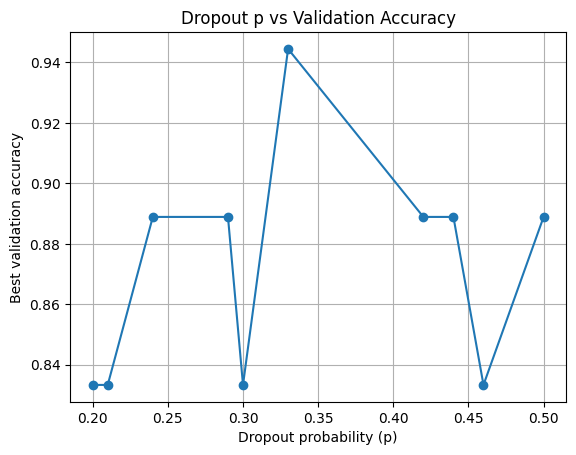

In [ ]:
p_acc = sorted(results.items())

p = [x[0] for x in p_acc]
acc = [x[1] for x in p_acc]

plt.figure()
plt.plot(p, acc, marker='o')
plt.xlabel('Dropout probability (p)')
plt.ylabel('Best validation accuracy')
plt.title('Dropout p vs Validation Accuracy')
plt.grid(True)
plt.show()

Видим, что можем получить очень хорошую точность на валиде с дропаутом около 0.33

## Train ResNet18

In [39]:
model = ResNet18(p=0.33, img_channel=3, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

num_epochs = 50
model, train_accuracies, valid_accuracies, train_losses, valid_losses = train_model(model, criterion, optimizer, scheduler, 
                                                                                    train_loader, test_loader,
                                                                                    device, num_epochs)

Epoch 1/50
Train Loss: 0.7973
Valid Loss: 4.3498 | Valid Acc: 0.5556
Epoch 2/50
Train Loss: 0.4367
Valid Loss: 1.5633 | Valid Acc: 0.4444
Epoch 3/50
Train Loss: 0.6674
Valid Loss: 1.0001 | Valid Acc: 0.7222
Epoch 4/50
Train Loss: 0.5809
Valid Loss: 3.3090 | Valid Acc: 0.5000
Epoch 5/50
Train Loss: 0.4803
Valid Loss: 1.2219 | Valid Acc: 0.5556
Epoch 6/50
Train Loss: 0.3271
Valid Loss: 1.1571 | Valid Acc: 0.5556
Epoch 7/50
Train Loss: 0.7333
Valid Loss: 0.8271 | Valid Acc: 0.7222
Epoch 8/50
Train Loss: 0.4286
Valid Loss: 0.4001 | Valid Acc: 0.8889
Epoch 9/50
Train Loss: 0.3853
Valid Loss: 0.6751 | Valid Acc: 0.7222
Epoch 10/50
Train Loss: 0.4169
Valid Loss: 0.6361 | Valid Acc: 0.7778
Epoch 11/50
Train Loss: 0.2994
Valid Loss: 1.0427 | Valid Acc: 0.6667
Epoch 12/50
Train Loss: 0.4184
Valid Loss: 1.1075 | Valid Acc: 0.6111
Epoch 13/50
Train Loss: 0.3177
Valid Loss: 0.8460 | Valid Acc: 0.8333
Epoch 14/50
Train Loss: 0.4191
Valid Loss: 1.0560 | Valid Acc: 0.5556
Epoch 15/50
Train Loss: 0.297

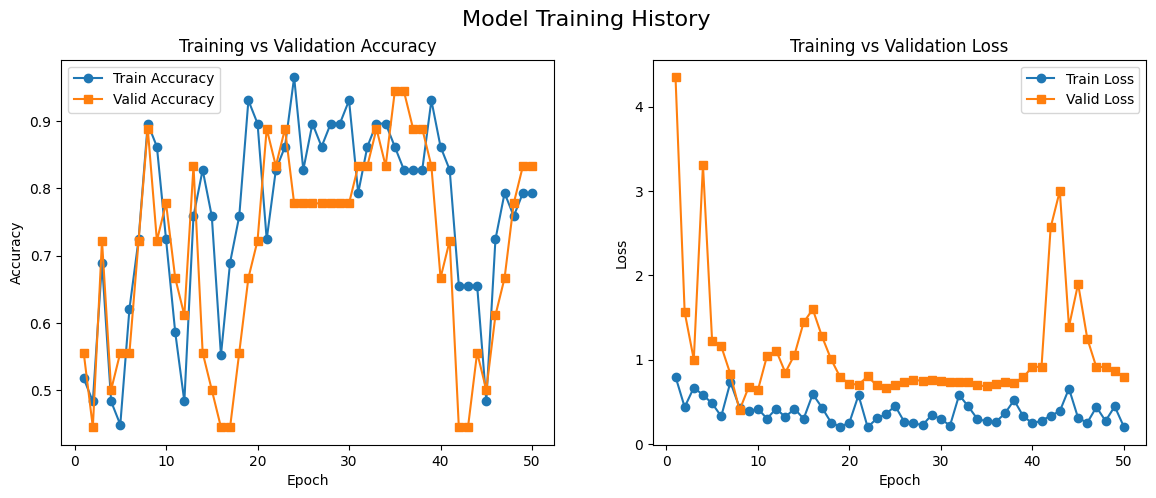

In [40]:
plot_training_history(
    train_accuracies, valid_accuracies, 
    train_losses, valid_losses, num_epochs,
    title="Model Training History"
)

In [ ]:
def evaluate_nn_model(model, loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            _, predicted = torch.max(pred, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

y_pred, y_true = evaluate_nn_model(model, test_loader, device)
y_pred = [class_names[x] for x in y_pred]
y_true = [class_names[x] for x in y_true]


Оценка ResNet18 

Accuracy : 0.8889
Precision: 0.8889
Recall   : 0.8889
F1-score : 0.8889

Отчёт по классам:
               precision    recall  f1-score   support

    contrast       0.89      0.89      0.89         9
         y2k       0.89      0.89      0.89         9

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18



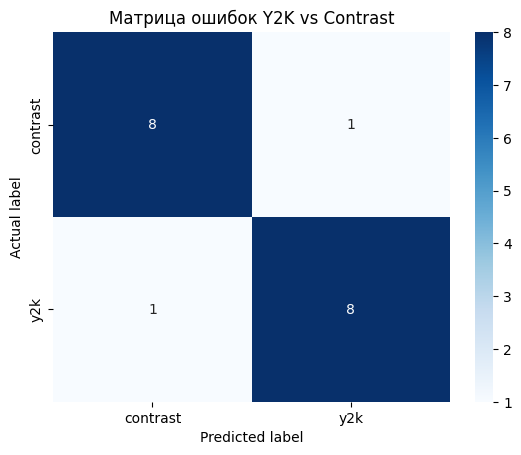

In [42]:
evaluate_model(y_pred, y_true, 'Оценка ResNet18 \n')
plot_confusion_matrix(y_true, y_pred, "Y2K vs Contrast")

In [43]:
PATH = '/Users/albertzagibin/Documents/Стартап/Тестовое/models/ResNet18.pth'

torch.save(model.state_dict(), PATH)

Проверка модели на тестовых изображениях из интернета

In [ ]:
model = ResNet18(p=0.4, img_channel=3, num_classes=2).to(device)
model.load_state_dict(torch.load(PATH))

In [ ]:
# подсчет уверенности модели в своем предсказании
def predict_with_conf(imgs, class_names):
    output = model(imgs)
    probs = F.softmax(output, dim=1)
    conf, preds = torch.max(probs, 1)
    return conf, preds, [class_names[x] for x in preds]

In [95]:
imgs = torch.randn(4, 3, 224, 224).to(device)
predict_with_conf(imgs, class_names)

(tensor([0.6429, 0.5119, 0.8664, 0.9807], device='mps:0',
        grad_fn=<MaxBackward0>),
 tensor([1, 0, 1, 1], device='mps:0'),
 ['y2k', 'contrast', 'y2k', 'y2k'])